In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [3]:
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

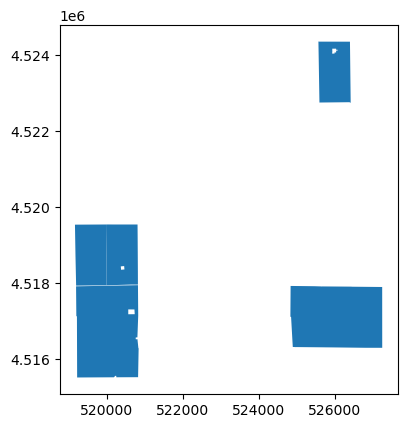

In [5]:
cper.plot()

In [8]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [9]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [10]:
cper_xr = cper_xr.where(cper_xr != 0)

In [11]:
pts_density_list = []

In [12]:
from tqdm import tqdm
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
            kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=56.42)
            pts_density_tmp = focal.apply(pts_xr.where(cper_xr == i),
                                                kernel, 
                                                focal._calc_sum).where(cper_xr == i)
            pts_density_list.append(pts_density_tmp.where(pts_density_tmp != 0))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.73s/it]


In [15]:
pts_density_xr = xr.DataArray(np.nanmean(pts_density_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))

/tmp/ipykernel_445/781102491.py:1: RuntimeWarning: Mean of empty slice
  pts_density_xr = xr.DataArray(np.nanmean(pts_density_list, axis=0),


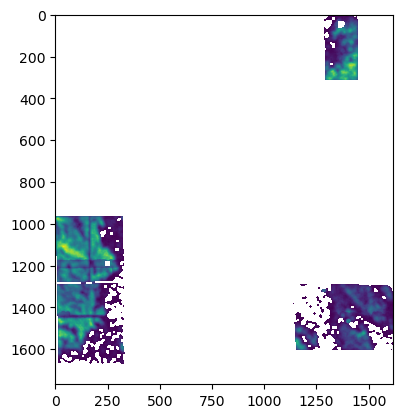

<AxesSubplot:>

In [16]:
show(pts_density_xr.data)

In [62]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

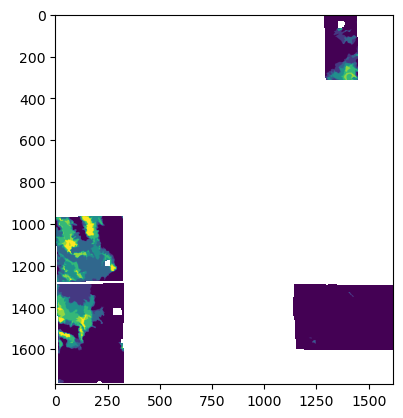

<AxesSubplot:>

In [63]:
show(da_active.data)

In [64]:
df_active = da_active.to_dataframe(name='yrs_active')
df_old = da_old.to_dataframe(name='yrs_old')
df_pts_density = pts_density_xr.to_dataframe(name='pts_density')

In [65]:
df_out = pd.merge(pd.merge(df_active, df_old, left_index=True, right_index=True),
                  df_pts_density, left_index=True, right_index=True)

In [66]:
df_out

band_x  spatial_ref_x  yrs_active  band_y  \
y            x                                                        
4.524365e+06 519167.8595       1              0         NaN       1   
             519172.8595       1              0         NaN       1   
             519177.8595       1              0         NaN       1   
             519182.8595       1              0         NaN       1   
             519187.8595       1              0         NaN       1   
...                          ...            ...         ...     ...   
4.515525e+06 527232.8595       1              0         NaN       1   
             527237.8595       1              0         NaN       1   
             527242.8595       1              0         NaN       1   
             527247.8595       1              0         NaN       1   
             527252.8595       1              0         NaN       1   

                          spatial_ref_y  yrs_old  pts_density  
y            x                                                 
4.524365e+06 519167.8595              0      NaN          NaN  
             519172.8595              0      NaN          NaN  
             519177.8595              0      NaN          NaN  
             519182.8595              0      NaN          NaN  
             519187.8595              0      NaN          NaN  
...                                 ...      ...          ...  
4.515525e+06 527232.8595              0      NaN          NaN  
             527237.8595              0      NaN          NaN  
             527242.8595              0      NaN          NaN  
             527247.8595              0      NaN          NaN  
             527252.8595              0      NaN          NaN  

[2862242 rows x 7 columns]

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

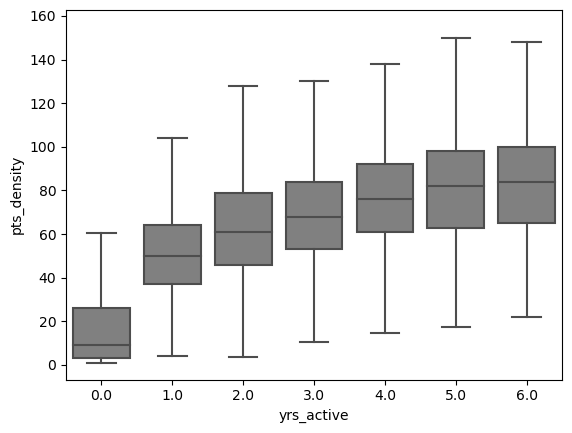

In [67]:
import seaborn as sns
sns.boxplot(x='yrs_active', y='pts_density', data=df_out, fliersize=0, color='grey')

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

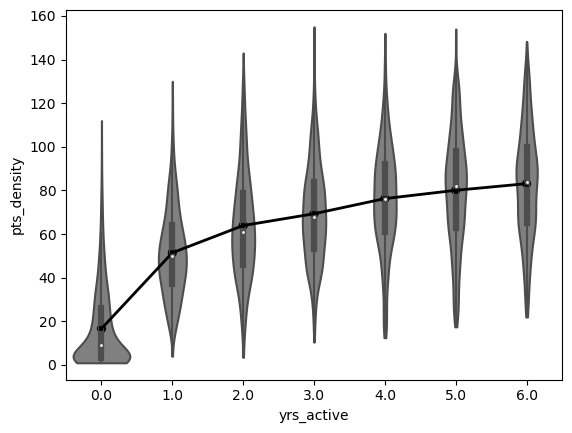

In [68]:
ax = sns.violinplot(x='yrs_active', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_active', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

<AxesSubplot:xlabel='yrs_old', ylabel='pts_density'>

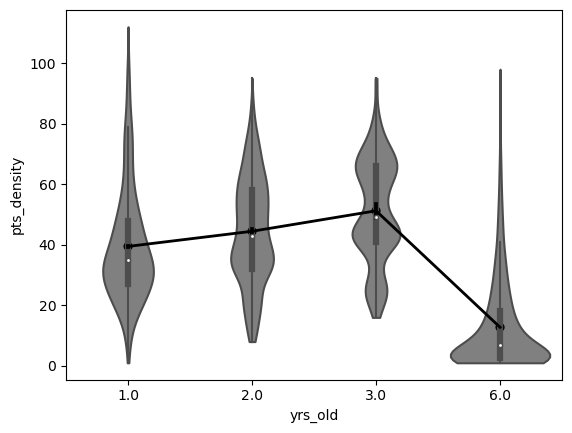

In [69]:
ax = sns.violinplot(x='yrs_old', y='pts_density', data=df_out, color='grey',
                    bw=0.25, cut=0, trim=True, scale='area')
sns.pointplot(x='yrs_old', y='pts_density', data=df_out, ax=ax, 
              color='black', scale=0.75)

In [71]:
from sklearn.metrics import jaccard_score

In [112]:
df_val = pd.DataFrame(columns=['yrs_thresh', 'pts_thresh', 'jscore'])
idx=0
for yrs_thresh in tqdm(range(0, 6)):
    for pts_thresh in range(1, 101, 2):
        df_out['y_true'] = df_out['yrs_active'] > yrs_thresh
        df_out['y_pred'] = df_out['pts_density'] > pts_thresh
        jscore = jaccard_score(y_true=df_out['y_true'],
                      y_pred=df_out['y_pred'])
        df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': yrs_thresh,
                                                  'pts_density': pts_thresh,
                                                  'jscore': jscore}, index=[idx])])
        idx+=1

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:04<00:00, 20.77s/it]


In [113]:
for pts_thresh in tqdm(range(1, 101, 2)):
    df_out['y_true'] = (df_out['yrs_active'] > 0) | (df_out['yrs_old'] == 1)
    df_out['y_pred'] = df_out['pts_density'] > pts_thresh
    jscore = jaccard_score(y_true=df_out['y_true'],
                  y_pred=df_out['y_pred'])
    df_val = pd.concat([df_val, pd.DataFrame({'yrs_thresh': -1,
                                              'pts_density': pts_thresh,
                                              'jscore': jscore}, index=[idx])])
    idx+=1
        

<AxesSubplot:xlabel='pts_density', ylabel='jscore'>

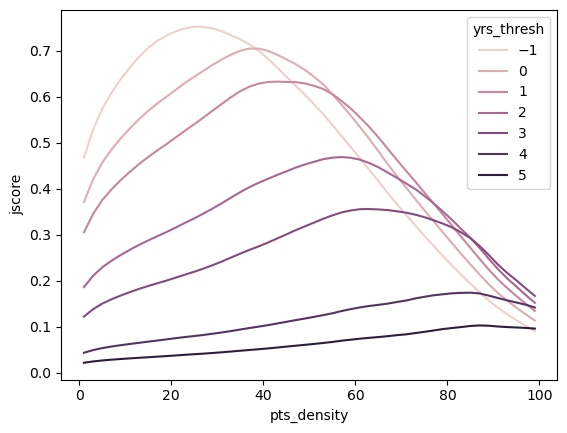

In [114]:
sns.lineplot(x='pts_density', y='jscore', data=df_val, hue='yrs_thresh')

In [115]:
df_val.groupby('yrs_thresh').apply(lambda x: x['pts_density'][x['jscore'] == x['jscore'].max()])

yrs_thresh     
-1          312    25.0
 0          18     37.0
 1          71     43.0
 2          128    57.0
 3          181    63.0
 4          242    85.0
 5          293    87.0
Name: pts_density, dtype: float64

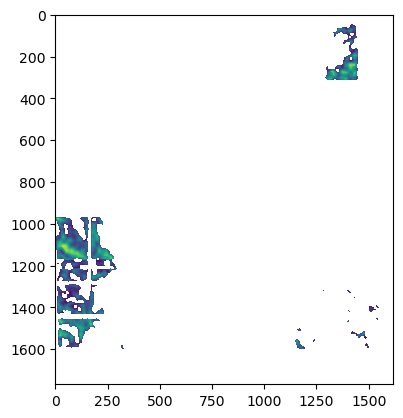

<AxesSubplot:>

In [127]:
pts_thresh = 37
show(pts_density_xr.where(pts_density_xr > pts_thresh).data)

In [128]:
((pts_density_xr > pts_thresh).sum()*5.0**2*0.0001).values

array(383.2375)

In [129]:
((da_active > 0).sum()*5.0**2*0.0001).values

array(337.8125)

In [130]:
((da_active > 0).sum()*5.0**2*0.0001).values + \
((da_old == 1).sum()*5.0**2*0.0001).values

425.52750000000003

In [131]:
((pts_density_xr > pts_thresh).where(cper_xr != 5).sum()*5.0**2*0.0001).values

array(350.9225)

In [132]:
((da_active > 0).where(cper_xr != 5).sum()*5.0**2*0.0001).values

array(337.115)